In [ ]:
# Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive

MyDrive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/tmdb_5000_movies_cleaned.csv')
df.head()


,genres_1,genres_2,budget,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,popularity,production_companies,revenue,runtime,title,vote_average,vote_count
0,Action,Adventure,237000000,cultureclash,future,spacewar,spacecolony,society,spacetravel,150.437577,Ingenious Film Partners,2787965087,162.0,Avatar,7.2,11800
1,Adventure,Fantasy,300000000,ocean,drugabuse,exoticisland,eastindiatradingcompany,loveofone'slife,traitor,139.082615,Walt Disney Pictures,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500
2,Action,Adventure,245000000,spy,basedonnovel,secretagent,sequel,mi6,britishsecretservice,107.376788,Columbia Pictures,880674609,148.0,Spectre,6.3,4466
3,Action,Crime,250000000,dccomics,crimefighter,terrorist,secretidentity,burglar,hostagedrama,112.312950,Legendary Pictures,1084939099,165.0,The Dark Knight Rises,7.6,9106
4,Action,Adventure,260000000,basedonnovel,mars,medallion,spacetravel,princess,alien,43.926995,Walt Disney Pictures,284139100,132.0,John Carter,6.1,2124


In [ ]:
#Summing up the number of missing rows in each column feature
print(df.isna().sum())
print("total samples:", len(df))

genres_1                  28
genres_2                 928
budget                     0
keyword_1                412
keyword_2                700
keyword_3                983
keyword_4               1327
keyword_5               1714
keyword_6               2171
popularity                 0
production_companies     355
revenue                    0
runtime                    2
title                      0
vote_average               0
vote_count                 0
dtype: int64
total samples: 4803


In [ ]:


fill_values = {
    'genres_1': 'Unknown', 'genres_2': 'Unknown',
    'budget': 0, 'keyword_1': 'Unknown', 'keyword_2': 'Unknown', 'keyword_3': 'Unknown',
    'keyword_4': 'Unknown', 'keyword_5': 'Unknown', 'keyword_6': 'Unknown',
    'popularity': 0, 'production_companies': 'Unknown', 'revenue': 0,
    'runtime': 0, 'vote_average': 0, 'vote_count': 0, 'title': 'Unknown'
}
df.fillna(fill_values, inplace=True)


In [ ]:
# Target Column
df['target'] = df['genres_1']
df.drop(['genres_1'], axis=1, inplace=True)

Class Distribution:
target
Drama              1207
Comedy             1042
Action              754
Adventure           339
Horror              300
Crime               195
Thriller            194
Animation           123
Fantasy             117
Romance             106
Science Fiction      96
Documentary          89
Family               56
Mystery              41
Music                34
Unknown              28
Western              27
History              25
War                  24
TV Movie              4
Foreign               2
Name: count, dtype: int64


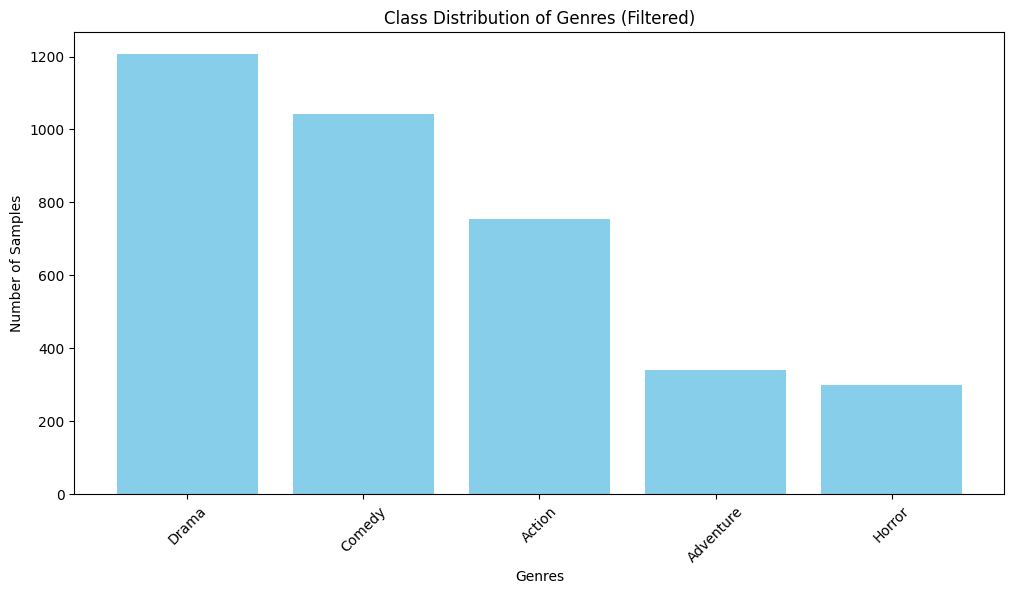

In [ ]:
class_distribution = df['target'].value_counts()
small_classes = class_distribution[class_distribution < 200].index
df_filtered = df[~df['target'].isin(small_classes)].reset_index(drop=True)

# -------------------------------
# Plot class distribution after filtering
# -------------------------------
filtered_distribution = df_filtered['target'].value_counts()
print("Class Distribution:")
print(class_distribution)
plt.figure(figsize=(12, 6))
plt.bar(filtered_distribution.index, filtered_distribution.values, color='skyblue')
plt.xlabel('Genres')
plt.ylabel('Number of Samples')
plt.title('Class Distribution of Genres (Filtered)')
plt.xticks(rotation=45)  # rotate labels for readability
plt.show()

In [ ]:
# Encode categorical columns
df_encoded = df_filtered.copy()
label_encoder = LabelEncoder()
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col != 'target':
        df_encoded[col] = label_encoder.fit_transform(df_encoded[col])


In [ ]:
# Encode target column
target_encoder = LabelEncoder()
df_encoded['target'] = target_encoder.fit_transform(df_encoded['target'])

In [ ]:
# Scale features
X = df_encoded.drop('target', axis=1)  # X must be a DataFrame
y = df_encoded['target']

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)  # X.columns exists because X is a DataFrame
df_scaled['target'] = y.values

In [ ]:
# Split data for train/dev/test
data = df_scaled.values
total_samples = len(data)
train = data[:int(total_samples*0.7)]
dev = data[int(total_samples*0.7):int(total_samples*0.85)]
test = data[int(total_samples*0.85):]
def get_features_and_labels(data):
    features = data[:, :-1]
    labels = data[:, -1]
    return features, labels

train_x, train_y = get_features_and_labels(train)
dev_x, dev_y = get_features_and_labels(dev)
test_x, test_y = get_features_and_labels(test)

In [ ]:
# KNN using scikit-learn
# Initialize KNN
knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
knn.fit(train_x, train_y)

# Predict on dev set
pred_labels_dev = knn.predict(dev_x)
accuracy_dev = accuracy_score(dev_y, pred_labels_dev)
print("Development Set Accuracy:", accuracy_dev)

Development Set Accuracy: 0.43772893772893773


In [ ]:
# Find optimal K
k_list = list(range(1, 102, 4))
performance = []
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(train_x, train_y)
    pred_labels = knn.predict(dev_x)
    performance.append(accuracy_score(dev_y, pred_labels))

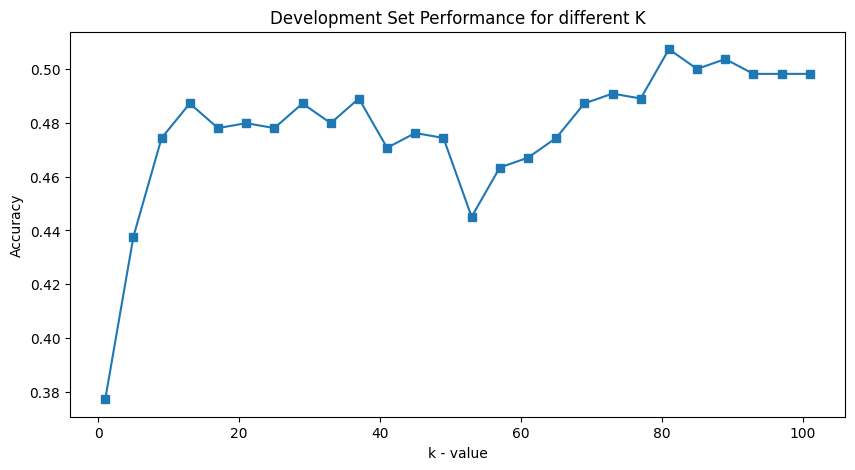

Optimal K: 81


In [ ]:
# Predict and Evaluate on Dev Set
plt.figure(figsize=(10,5))
plt.plot(k_list, performance, marker='s')
plt.xlabel('k - value')
plt.ylabel('Accuracy')
plt.title('Development Set Performance for different K')
plt.show()

optimal_k = k_list[np.argmax(performance)]
print("Optimal K:", optimal_k)



In [ ]:
# Test set evaluation with optimal K
knn = KNeighborsClassifier(n_neighbors=optimal_k, metric='manhattan')
knn.fit(train_x, train_y)
pred_labels_test = knn.predict(test_x)
accuracy_test = accuracy_score(test_y, pred_labels_test)
mae = mean_absolute_error(test_y, pred_labels_test)
mse = mean_squared_error(test_y, pred_labels_test)

print("Test Set Accuracy:", accuracy_test)
print("MAE:", mae)
print("MSE:", mse)


Test Set Accuracy: 0.4076782449725777
MAE: 0.8976234003656307
MSE: 1.6691042047531992


In [ ]:
# Multi-class Logistic Regression
train_x_lr, test_x_lr, train_y_lr, test_y_lr = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model_lr = LogisticRegression(multi_class='multinomial', max_iter=2000, C=0.001)
model_lr.fit(train_x_lr, train_y_lr)
y_pred_lr = model_lr.predict(test_x_lr)

accuracy_lr = accuracy_score(test_y_lr, y_pred_lr)
recall_lr = classification_report(test_y_lr, y_pred_lr, output_dict=True, zero_division=1)['weighted avg']['recall']
f1_lr = classification_report(test_y_lr, y_pred_lr, output_dict=True, zero_division=1)['weighted avg']['f1-score']

print("Logistic Regression Accuracy:", accuracy_lr)
print("Weighted Avg Recall:", recall_lr)
print("Weighted Avg F1 Score:", f1_lr)

Logistic Regression Accuracy: 0.3497942386831276
Weighted Avg Recall: 0.3497942386831276
Weighted Avg F1 Score: 0.18129579443942587


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
